## Wrangle & Analyze "WeRateDogs" Data

**Table of Contents**
 1. Introduction
 2. Gathering data
 3. Assessing data
 4. Cleaning data
 5. Storing, Analyzing, and Visualizing

**Introduction**

**The purpose of this project is to demonsrtize the skills we learned in data wrangling part of Udacity Data Analysis Nanodegree program**


### Gathering data:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import requests
from functools import reduce
from datetime import datetime
import json 
import re
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer

In [2]:
pip install tweepy 

Note: you may need to restart the kernel to use updated packages.


 #### 1. The WeRateDogs Twitter archive :

The WeRateDogs Twitter archive. I am giving this file to you, so imagine it as a file on hand. Download this file manually by clicking the following link: twitter_archive_enhanced.csv

In [3]:
# load twitter archive
twitter_archive = pd.read_csv("twitter-archive-enhanced.csv")
display(twitter_archive.head())

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


#### 2. Tweet image prediction

The tweet image predictions, i.e., what breed of dog (or other object, animal, etc.) is present in each tweet according to a neural network. This file (image_predictions.tsv) is hosted on Udacity's servers and should be downloaded programmatically using the Requests library and the following URL: https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv

In [4]:
#downloaded programmatically using the Requests library and the following URL

url =  'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
with open('image-predictions.tsv' , 'wb') as file:
    image_predictions = requests.get(url)
    file.write(image_predictions.content)
    
image_predictions_df= pd.read_csv('image-predictions.tsv' , sep = '\t')
display(image_predictions_df.head())

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


#### 3. Twitter API File


In [5]:
# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

In [6]:
api_data = []

#read the created file
with open("tweet-json.txt", "r") as f:
    for line in f:
        try: 
            tweet = json.loads(line)
            #append a dictionary to the created list            
            api_data.append({
                "tweet_id": tweet["id"],
                "retweet_count": tweet["retweet_count"],
                "favorite_count": tweet["favorite_count"],                
            })               
            
        except:
            print("Error.") 
            
twitter_api= pd.DataFrame(api_data, columns = ["tweet_id", "retweet_count", "favorite_count"])
display(twitter_api.head())

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048


In [7]:
# load twitter API data
#with open('tweet-json.txt') as f:
    #twitter_api = pd.DataFrame((json.loads(line) for line in f), columns = ['id', 'favorite_count', 'retweet_count'])
#display(twitter_api.head())

### Assessing data for this project

#### WeRateDogs Twitter archive asses:

In [8]:
display(twitter_archive.head())

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [9]:
display(twitter_archive.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

None

In [10]:
display(twitter_archive.isnull().sum())

tweet_id                         0
in_reply_to_status_id         2278
in_reply_to_user_id           2278
timestamp                        0
source                           0
text                             0
retweeted_status_id           2175
retweeted_status_user_id      2175
retweeted_status_timestamp    2175
expanded_urls                   59
rating_numerator                 0
rating_denominator               0
name                             0
doggo                            0
floofer                          0
pupper                           0
puppo                            0
dtype: int64

In [11]:
#checking duplicates in dataframe
print('duplicate rows:',twitter_archive.duplicated().sum())

duplicate rows: 0


In [12]:
#Checking the descriptive statistics 
display(twitter_archive.describe())

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


<AxesSubplot:xlabel='rating_numerator'>

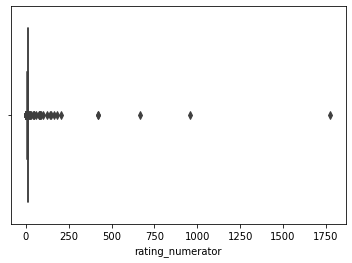

In [13]:
sns.boxplot(x=twitter_archive['rating_numerator'])

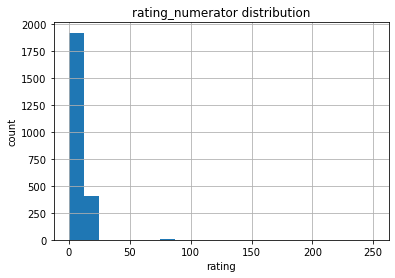

In [14]:
twitter_archive.hist('rating_numerator', bins = 20,range=(0,250))
plt.title('rating_numerator distribution')
plt.xlabel("rating")
plt.ylabel("count")
plt.show()

<AxesSubplot:xlabel='rating_denominator'>

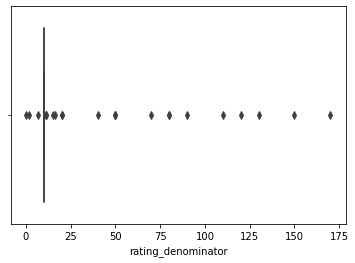

In [15]:
sns.boxplot(x=twitter_archive['rating_denominator'])

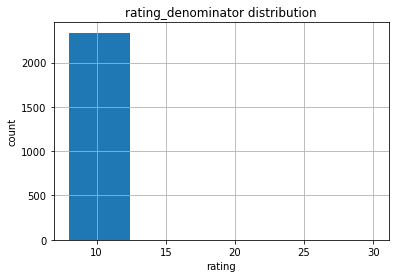

In [16]:
twitter_archive.hist('rating_denominator', bins = 5,range=(8,30))
plt.title('rating_denominator distribution')
plt.xlabel("rating")
plt.ylabel("count")
plt.show()

In [17]:
#Checking the dog names
dog_names_list = []
dog_names_list = twitter_archive['name'].unique()
dog_names_list.sort()
display(dog_names_list)

array(['Abby', 'Ace', 'Acro', 'Adele', 'Aiden', 'Aja', 'Akumi', 'Al',
       'Albert', 'Albus', 'Aldrick', 'Alejandro', 'Alexander',
       'Alexanderson', 'Alf', 'Alfie', 'Alfy', 'Alice', 'Amber',
       'Ambrose', 'Amy', 'Amélie', 'Anakin', 'Andru', 'Andy', 'Angel',
       'Anna', 'Anthony', 'Antony', 'Apollo', 'Aqua', 'Archie', 'Arlen',
       'Arlo', 'Arnie', 'Arnold', 'Arya', 'Ash', 'Asher', 'Ashleigh',
       'Aspen', 'Astrid', 'Atlas', 'Atticus', 'Aubie', 'Augie', 'Autumn',
       'Ava', 'Axel', 'Bailey', 'Baloo', 'Balto', 'Banditt', 'Banjo',
       'Barclay', 'Barney', 'Baron', 'Barry', 'Batdog', 'Bauer', 'Baxter',
       'Bayley', 'BeBe', 'Bear', 'Beau', 'Beckham', 'Beebop', 'Beemo',
       'Bell', 'Bella', 'Belle', 'Ben', 'Benedict', 'Benji', 'Benny',
       'Bentley', 'Berb', 'Berkeley', 'Bernie', 'Bert', 'Bertson',
       'Betty', 'Beya', 'Biden', 'Bilbo', 'Billl', 'Billy', 'Binky',
       'Birf', 'Bisquick', 'Blakely', 'Blanket', 'Blipson', 'Blitz',
       'Bloo', 'Bloop',

In [18]:
# check rating denominator
display(twitter_archive['rating_denominator'].value_counts())

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [19]:
# check ratings with denominator greather than 10
display(twitter_archive.query(' rating_denominator > 10 '))

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
342,832088576586297345,8.320875e+17,3.058208e+07,2017-02-16 04:45:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@docmisterio account started on 11/15/15,NaN,NaN,NaN,NaN,11,15,None,None,None,None,None
433,820690176645140481,NaN,NaN,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",The floofs have been released I repeat the flo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/820690176...,84,70,None,None,None,None,None
784,775096608509886464,NaN,NaN,2016-09-11 22:20:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: After so many requests, this is...",7.403732e+17,4.196984e+09,2016-06-08 02:41:38 +0000,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None
902,758467244762497024,NaN,NaN,2016-07-28 01:00:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Why does this never happen at my front door......,NaN,NaN,NaN,https://twitter.com/dog_rates/status/758467244...,165,150,None,None,None,None,None
1068,740373189193256964,NaN,NaN,2016-06-08 02:41:38 +0000,"<a href=""http://twitter.com/download/iphone"" r...","After so many requests, this is Bretagne. She ...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None
1120,731156023742988288,NaN,NaN,2016-05-13 16:15:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to this unbelievably well behaved sq...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/731156023...,204,170,this,None,None,None,None
1165,722974582966214656,NaN,NaN,2016-04-21 02:25:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Happy 4/20 from the squad! 13/10 for all https...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/722974582...,4,20,None,None,None,None,None
1202,716439118184652801,NaN,NaN,2016-04-03 01:36:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bluebert. He just saw that both #Final...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/716439118...,50,50,Bluebert,None,None,None,None
1228,713900603437621249,NaN,NaN,2016-03-27 01:29:02 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Happy Saturday here's 9 puppers on a bench. 99...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/713900603...,99,90,None,None,None,None,None
1254,710658690886586372,NaN,NaN,2016-03-18 02:46:49 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a brigade of puppers. All look very pre...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/710658690...,80,80,None,None,None,None,None


In [20]:
#identify the rating with 0
display(twitter_archive.query(' rating_denominator == 0 '))

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
313,835246439529840640,8.352460e+17,26259576.0,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,NaN,NaN,NaN,960,0,None,None,None,None,None


In [21]:
# check rating denominator
display(twitter_archive['rating_numerator'].value_counts())

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [22]:
# check for two or more urls in the expanded urls
twitter_archive[twitter_archive.expanded_urls.str.contains(',', na = False)].expanded_urls.count()

639

**Quality in twitter_archive**

1. timestamp and retweeted_status_timestamp must be of datetime instead of the object.
2. There is no duplicated row founded.
3. Missing values are present in columns in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id , retweeted_status_user_id, retweeted_status_timestamp, expanded_urls
4. Some og the values in rating_numerator and rating_denominator columns incosistent values not acceptable values. For example 
rating_denominator max value is 170 and min value is 0.
5. 639 expanded urls which contain more than one url address
6. Dog 'stage' classification (doggo, floofer, pupper or puppo) should be one column.
7. tweet id 835246439529840640 has a rating of denominator = 0
8. Crazy names found for dogs - 'infuriating', 'just', 'life', 'light', 'mad', 'my', 'not', 'officially', 'old', 'one', 'quite', 'space', 'such', 'the', 'this', 'unacceptable', 'very'

**Tidiness in twitter_archive**

1. This twitter_archive is like a main base table with the above attributes, there will be other attributes other dataframes. Hence we need to join all other dataframes to get a final dataframe.
1. Dog 'stage' classification (doggo, floofer, pupper or puppo) should be one column.
1. Some dogs have more than one category assigned.




### Image Predictions asses :

In [23]:
display(image_predictions_df.head())

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [24]:
# print a summary of a DataFrame
display(image_predictions_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


None

In [25]:
display(image_predictions_df.isnull().sum())

tweet_id    0
jpg_url     0
img_num     0
p1          0
p1_conf     0
p1_dog      0
p2          0
p2_conf     0
p2_dog      0
p3          0
p3_conf     0
p3_dog      0
dtype: int64

In [26]:
#checking duplicates in dataframe
print('duplicate rows:',image_predictions_df.duplicated().sum())

duplicate rows: 0


In [27]:
#Checking the descriptive statistics 
display(image_predictions_df.describe())

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [28]:
display(image_predictions_df.img_num.value_counts())

1    1780
2     198
3      66
4      31
Name: img_num, dtype: int64

In [29]:
# check jpg_url to confirm if it contains only jpg and png images
image_predictions_df[~image_predictions_df.jpg_url.str.endswith(('.jpg', '.png'), na = False)].jpg_url.count()

0

#### Quality & Tidiness Issues in Image Predictions:

1. The dataset has 2075 row, 12 colums.

2. Column names are confusing and do not give much information about the content.

3. Dog breeds contain underscores, and have different case formatting.

4. 66 jpg_url duplicates were found.

5. Dataset should be merged with the twitter archive dataset.

### Twitter API Data Assess:

In [30]:
display(twitter_api.head())

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048


<AxesSubplot:xlabel='favorite_count'>

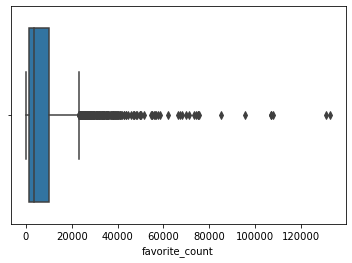

In [31]:
sns.boxplot(x=twitter_api['favorite_count'])

<AxesSubplot:xlabel='retweet_count'>

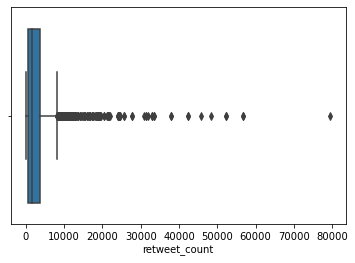

In [32]:
sns.boxplot(x=twitter_api['retweet_count'])

In [33]:
# print a summary of a DataFrame
display(twitter_api.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2354 non-null   int64
 1   retweet_count   2354 non-null   int64
 2   favorite_count  2354 non-null   int64
dtypes: int64(3)
memory usage: 55.3 KB


None

In [34]:
display(twitter_api.describe())

,tweet_id,retweet_count,favorite_count
count,2.354000e+03,2354.000000,2354.000000
mean,7.426978e+17,3164.797366,8080.968564
std,6.852812e+16,5284.770364,11814.771334
min,6.660209e+17,0.000000,0.000000
25%,6.783975e+17,624.500000,1415.000000
50%,7.194596e+17,1473.500000,3603.500000
75%,7.993058e+17,3652.000000,10122.250000
max,8.924206e+17,79515.000000,132810.000000


In [35]:
#checking duplicates in dataframe
print('duplicate rows:',twitter_api.duplicated().sum())

duplicate rows: 0


In [36]:
display(twitter_api.isnull().sum())

tweet_id          0
retweet_count     0
favorite_count    0
dtype: int64

##### Quality & Tidiness Issues in Twitter API Data

1. twitter API data has 2354 rows,3 columns.

1. dataset should be merged with the twitter archive dataset.

### Cleaning Data:


#### twitter_archive clean:

In [37]:
twitter_archive_clean = twitter_archive.copy()
display(twitter_archive_clean.head(2))

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None


#### Define 1: Outliers removed in the rating_numerator and rating_denominator columns

#### Code 1:

In [38]:
#Determine the upper and lower limits of outliers and remove the outliers(rating_numerator column) using IQR rule

uw_1 =(twitter_archive_clean['rating_numerator'].quantile(0.75))+(1.5*((twitter_archive_clean['rating_numerator'].quantile(0.75))-(twitter_archive_clean['rating_numerator'].quantile(0.25))))
lw_1=(twitter_archive_clean['rating_numerator'].quantile(0.25))-(1.5*((twitter_archive_clean['rating_numerator'].quantile(0.75))-(twitter_archive_clean['rating_numerator'].quantile(0.25))))
print(uw_1)
print(lw_1)
twitter_archive_clean = twitter_archive_clean.query(' @lw_1 <= rating_numerator <= @uw_1 ')
display(twitter_archive_clean.head())

15.0
7.0


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [39]:
#Determine the upper and lower limits of outliers and remove the outliers(rating_denominator column) IQR rule

uw_2 =(twitter_archive_clean['rating_denominator'].quantile(0.75))+(1.5*((twitter_archive_clean['rating_denominator'].quantile(0.75))-(twitter_archive_clean['rating_denominator'].quantile(0.25))))
lw_2=(twitter_archive_clean['rating_denominator'].quantile(0.25))-(1.5*((twitter_archive_clean['rating_denominator'].quantile(0.75))-(twitter_archive_clean['rating_denominator'].quantile(0.25))))
print(uw_2)
print(lw_2)
twitter_archive_clean = twitter_archive_clean.query(' @lw_2 <= rating_denominator <= @uw_2 ')
display(twitter_archive_clean.head())

10.0
10.0


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


#### Test 1:

<AxesSubplot:xlabel='rating_numerator'>

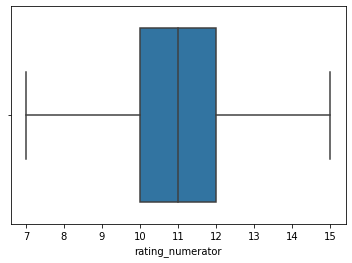

In [40]:
sns.boxplot(x=twitter_archive_clean['rating_numerator'])

<AxesSubplot:xlabel='rating_denominator'>

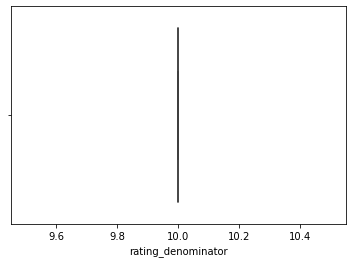

In [41]:
sns.boxplot(x=twitter_archive_clean['rating_denominator'])

#### Define 2: Drop unnecessary columns in twitter_archive_clean

#### Code 2 : 

In [42]:
# drop unnecessary columns in twitter_archive_clean
twitter_archive_clean.drop(['in_reply_to_status_id','in_reply_to_user_id','retweeted_status_id',
                            'retweeted_status_user_id','retweeted_status_timestamp'], axis = 1, inplace = True)

#### Test 2 :

In [43]:
display(twitter_archive_clean.head(2))

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None


#### Define 3 : convert tweet_id to string and timestamp convert to datetime

#### Code 3 :

In [44]:
#convert tweet_id to string

twitter_archive_clean['tweet_id'] = twitter_archive_clean['tweet_id'].astype(str)

# timestamp convert to datetime
twitter_archive_clean['timestamp'] = pd.to_datetime(twitter_archive_clean['timestamp'])

#### Test 3 :

In [45]:
display(twitter_archive_clean.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2201 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2201 non-null   object             
 1   timestamp           2201 non-null   datetime64[ns, UTC]
 2   source              2201 non-null   object             
 3   text                2201 non-null   object             
 4   expanded_urls       2155 non-null   object             
 5   rating_numerator    2201 non-null   int64              
 6   rating_denominator  2201 non-null   int64              
 7   name                2201 non-null   object             
 8   doggo               2201 non-null   object             
 9   floofer             2201 non-null   object             
 10  pupper              2201 non-null   object             
 11  puppo               2201 non-null   object             
dtypes: datetime64[ns, UTC](1), int64(2

None

#### Define 4 : Dog classification (doggo, floofer, pupper or puppo) columms making one single column.

#### Code 4 :

In [46]:
categories = ['doggo', 'floofer', 'pupper', 'puppo']

for category in categories:
    twitter_archive_clean[category] = twitter_archive_clean[category].apply(lambda x: 0 if x == 'None' else 1)

In [47]:
# Dog classification (doggo, floofer, pupper or puppo) columms making one single column.

for index, column in twitter_archive_clean.iterrows():
    for word in ['puppo', 'pupper', 'doggo', 'floofer']:
        if word.lower() in str(twitter_archive_clean.loc[index, 'text']).lower():
            twitter_archive_clean.loc[index, 'dog_type'] = word.title()
            
# drop old columns
twitter_archive_clean.drop(['puppo',
                       'pupper',
                       'doggo',
                       'floofer'],
                      axis=1, inplace=True)


#### Test 4: 

In [48]:
display(twitter_archive_clean.head(5))

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_type
0,892420643555336193,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,NaN
1,892177421306343426,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN
2,891815181378084864,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,NaN
3,891689557279858688,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,NaN
4,891327558926688256,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,NaN


#### Define 5: Remove the data which have rating denominator gretater than 10

#### Code 5: 

In [49]:
# remove the data which have rating denominator gretater than 10
twitter_archive_clean = twitter_archive_clean.query(' rating_denominator <= 10 ')

#### Test 5:

In [50]:
display(twitter_archive_clean.query(' rating_denominator > 10 '))

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_type


#### Define 6:Null value of column dog_type is filled with the mode value for each source

#### Code 6:

In [51]:
#null value of column dog_type is filled with the mode value for each source
twitter_archive_clean['dog_type'] = twitter_archive_clean.groupby('source')['dog_type'].transform(lambda grp:grp.fillna(grp.mode()[0]))

#### Test 6:

In [52]:
display(twitter_archive_clean.isnull().sum())

tweet_id               0
timestamp              0
source                 0
text                   0
expanded_urls         46
rating_numerator       0
rating_denominator     0
name                   0
dog_type               0
dtype: int64

#### Image_predictions_df clean:

In [53]:
display(image_predictions_df.head())

# create a copy of dataset
image_prediction_df_clean = image_predictions_df.copy()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


#### Define 1: Change column labels

#### Code 1: 

In [54]:
# change labels
image_prediction_df_clean.columns = ['tweet_id','image_url', 
                            'img_number', 
                            '1st_prediction',
                            '1st_prediction_confidence',
                            '1st_prediction_isdog',
                            '2nd_prediction',
                            '2nd_prediction_confidence',
                            '2nd_prediction_isdog',
                            '3rd_prediction',
                            '3rd_prediction_confidence',
                            '3rd_prediction_isdog']

#### Test 1: 

In [55]:
display(image_prediction_df_clean.head())

,tweet_id,image_url,img_number,1st_prediction,1st_prediction_confidence,1st_prediction_isdog,2nd_prediction,2nd_prediction_confidence,2nd_prediction_isdog,3rd_prediction,3rd_prediction_confidence,3rd_prediction_isdog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


#### Define 2: Remove underscore and capitalize the first letter of each word

#### Code 2:

In [56]:
# columns with dog breed
dog_breed_cols = ['1st_prediction', '2nd_prediction', '3rd_prediction']

# remove underscore and capitalize the first letter of each word 
for column in dog_breed_cols:
    image_prediction_df_clean[column] = image_prediction_df_clean[column].str.replace('_', ' ').str.title()

#### Test 2: 

In [57]:
display(image_prediction_df_clean.head())

,tweet_id,image_url,img_number,1st_prediction,1st_prediction_confidence,1st_prediction_isdog,2nd_prediction,2nd_prediction_confidence,2nd_prediction_isdog,3rd_prediction,3rd_prediction_confidence,3rd_prediction_isdog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh Springer Spaniel,0.465074,True,Collie,0.156665,True,Shetland Sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,Redbone,0.506826,True,Miniature Pinscher,0.074192,True,Rhodesian Ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German Shepherd,0.596461,True,Malinois,0.138584,True,Bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian Ridgeback,0.408143,True,Redbone,0.360687,True,Miniature Pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,Miniature Pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


#### Define 3 : Build function to determine dog breed

#### Code 3:

In [58]:
# build function to determine dog breed
# if no breed detected, set value to NaN

def get_breed(row):
    if row['1st_prediction_isdog'] == True:
        return row['1st_prediction'], row['1st_prediction_confidence']
    if row['2nd_prediction_isdog'] == True:
        return row['2nd_prediction'], row['2nd_prediction_confidence']
    if row['3rd_prediction_isdog'] == True:
        return row['3rd_prediction'], row['3rd_prediction_confidence']
    return np.nan, np.nan

# apply function to dataset
# create new columns with data
image_prediction_df_clean[['breed_predicted', 'prediction_confidence']] = pd.DataFrame(image_prediction_df_clean.apply(lambda row: 
                                                        get_breed(row), axis = 1).tolist(), index = image_prediction_df_clean.index) 

# drop old columns
image_prediction_df_clean.drop(['1st_prediction',
                       '1st_prediction_confidence',
                       '1st_prediction_isdog',
                       '2nd_prediction',
                       '2nd_prediction_confidence',
                       '2nd_prediction_isdog',
                       '3rd_prediction',
                       '3rd_prediction_confidence',
                       '3rd_prediction_isdog'],
                      axis=1, inplace=True)

# drop rows without dog breed prediction
image_prediction_df_clean.dropna(subset = ['breed_predicted', 'prediction_confidence'], inplace = True)


#### Test 3:

In [59]:
display(image_prediction_df_clean.head(1))

,tweet_id,image_url,img_number,breed_predicted,prediction_confidence
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh Springer Spaniel,0.465074


#### Twitter api clean:

In [60]:
twitter_api_clean = twitter_api.copy()
display(twitter_api_clean.head(2))

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819


#### Define 1 : Outliers remove from favorite_count and retweet columns

#### Code 1:

In [61]:
#Determine the upper and lower limits of outliers and remove the outliers(favorite_count column) IQR rule

uw_3 =(twitter_api_clean['favorite_count'].quantile(0.75))+(1.5*((twitter_api_clean['favorite_count'].quantile(0.75))-(twitter_api_clean['favorite_count'].quantile(0.25))))
lw_3=(twitter_api_clean['favorite_count'].quantile(0.25))-(1.5*((twitter_api_clean['favorite_count'].quantile(0.75))-(twitter_api_clean['favorite_count'].quantile(0.25))))
print(uw_3)
print(lw_3)
twitter_api_clean = twitter_api_clean.query(' @lw_3 <= favorite_count <= @uw_3 ')

23183.125
-11645.875


In [62]:
#Determine the upper and lower limits of outliers and remove the outliers(retweet_count column) IQR rule

uw_4 =(twitter_api_clean['retweet_count'].quantile(0.75))+(1.5*((twitter_api_clean['retweet_count'].quantile(0.75))-(twitter_api_clean['retweet_count'].quantile(0.25))))
lw_4=(twitter_api_clean['retweet_count'].quantile(0.25))-(1.5*((twitter_api_clean['retweet_count'].quantile(0.75))-(twitter_api_clean['retweet_count'].quantile(0.25))))
print(uw_4)
print(lw_4)
twitter_api_clean= twitter_api_clean.query(' @lw_4 <= retweet_count <= @uw_4 ')

6204.75
-2795.25


#### Test 1:

<AxesSubplot:xlabel='retweet_count'>

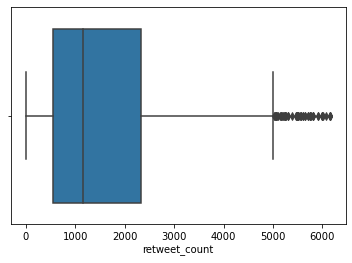

In [63]:
sns.boxplot(x=twitter_api_clean['retweet_count'])

<AxesSubplot:xlabel='favorite_count'>

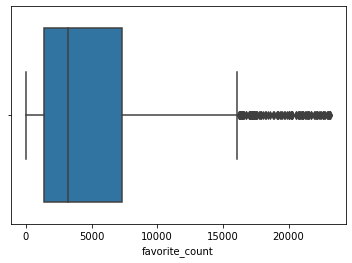

In [64]:
sns.boxplot(x=twitter_api_clean['favorite_count'])

#### Define 2 : Rename tweet_id column

#### Code 2 :

In [65]:
twitter_api_clean.rename(columns = {'id':'tweet_id'}, inplace = True)

twitter_api_clean['tweet_id'] = twitter_api_clean['tweet_id'].astype(str)
image_prediction_df_clean['tweet_id'] = image_prediction_df_clean['tweet_id'].astype(str)


#### Test 2:

In [66]:
display(twitter_api_clean.head(1))

,tweet_id,retweet_count,favorite_count
5,891087950875897856,3261,20562


#### Define 3: Merging 3 dataframe together

#### Code 3:

In [67]:
data_frames = [twitter_archive_clean, image_prediction_df_clean, twitter_api_clean]
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['tweet_id'],
                                            how='outer'), data_frames).fillna(0)

#### Test 3:

In [68]:
display(df_merged.head(1))

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_type,image_url,img_number,breed_predicted,prediction_confidence,retweet_count,favorite_count
0,892420643555336193,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13.0,10.0,Phineas,Pupper,0,0.0,0,0.0,0.0,0.0


In [69]:
df_merged['rating'] = df_merged['rating_numerator'] / df_merged['rating_denominator']

#### Define 4:  Drop rating_numerator and rating_denominator columns

#### Code 4 :

In [70]:
# drop rating_numerator and rating_denominator columns
df_merged.drop(['rating_denominator','rating_numerator'],axis=1, inplace=True)

#### Test 4 :

In [71]:
display(df_merged.head(1))

,tweet_id,timestamp,source,text,expanded_urls,name,dog_type,image_url,img_number,breed_predicted,prediction_confidence,retweet_count,favorite_count,rating
0,892420643555336193,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,Phineas,Pupper,0,0.0,0,0.0,0.0,0.0,1.3


In [72]:
display(df_merged.info())
display(df_merged.isnull().sum())
print('duplicate rows:',df_merged.duplicated().sum())
display(df_merged.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2352 entries, 0 to 2351
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   tweet_id               2352 non-null   object 
 1   timestamp              2352 non-null   object 
 2   source                 2352 non-null   object 
 3   text                   2352 non-null   object 
 4   expanded_urls          2352 non-null   object 
 5   name                   2352 non-null   object 
 6   dog_type               2352 non-null   object 
 7   image_url              2352 non-null   object 
 8   img_number             2352 non-null   float64
 9   breed_predicted        2352 non-null   object 
 10  prediction_confidence  2352 non-null   float64
 11  retweet_count          2352 non-null   float64
 12  favorite_count         2352 non-null   float64
 13  rating                 2201 non-null   float64
dtypes: float64(5), object(9)
memory usage: 275.6+ KB


None

tweet_id                   0
timestamp                  0
source                     0
text                       0
expanded_urls              0
name                       0
dog_type                   0
image_url                  0
img_number                 0
breed_predicted            0
prediction_confidence      0
retweet_count              0
favorite_count             0
rating                   151
dtype: int64

duplicate rows: 0


,img_number,prediction_confidence,retweet_count,favorite_count,rating
count,2352.000000,2352.000000,2352.000000,2352.000000,2201.000000
mean,0.904337,0.408709,1372.690476,4320.845238,1.106134
std,0.725508,0.351879,1418.685736,5095.259596,0.155778
min,0.000000,0.000000,0.000000,0.000000,0.700000
25%,0.000000,0.000000,250.000000,494.750000,1.000000
50%,1.000000,0.378397,899.000000,2593.500000,1.100000
75%,1.000000,0.734849,2088.500000,6005.250000,1.200000
max,4.000000,0.999956,6159.000000,23177.000000,1.500000


<AxesSubplot:xlabel='rating'>

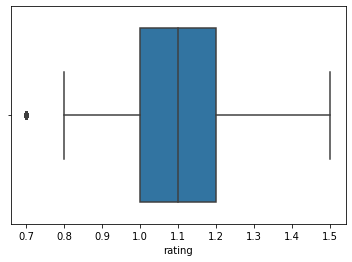

In [73]:
sns.boxplot(x=df_merged['rating'])

#### Define 5: Null value of column rating is filled with the median value using trasnform method of breed_predicted column as it has outliers

#### code 5 :

In [74]:
df_merged['rating'] = df_merged.groupby('breed_predicted')['rating'].transform(lambda x: x.fillna(x.median()))
df_merged.dropna(inplace=True)

#### Test 5:

In [75]:
display(df_merged.isnull().sum())

tweet_id                 0
timestamp                0
source                   0
text                     0
expanded_urls            0
name                     0
dog_type                 0
image_url                0
img_number               0
breed_predicted          0
prediction_confidence    0
retweet_count            0
favorite_count           0
rating                   0
dtype: int64

In [76]:
display(df_merged.head())

,tweet_id,timestamp,source,text,expanded_urls,name,dog_type,image_url,img_number,breed_predicted,prediction_confidence,retweet_count,favorite_count,rating
0,892420643555336193,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,Phineas,Pupper,0,0.0,0,0.000000,0.0,0.0,1.3
1,892177421306343426,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,Tilly,Pupper,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1.0,Chihuahua,0.323581,0.0,0.0,1.3
2,891815181378084864,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,Archie,Pupper,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1.0,Chihuahua,0.716012,0.0,0.0,1.2
3,891689557279858688,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,Darla,Pupper,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1.0,Labrador Retriever,0.168086,0.0,0.0,1.3
4,891327558926688256,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,Franklin,Pupper,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2.0,Basset,0.555712,0.0,0.0,1.2


### Storing, Analyzing, and Visualizing Data

#### Data store:

In [77]:
df_merged.to_csv('twitter_archive_master.csv', encoding='utf-8', index=False)

### Analyzing and Visualizing Data

#### Insight one : Top Dog type values based on the count

In [78]:
# Top Dog_stage values based on the count
cnt = df_merged.pivot_table(index = 'dog_type',values = 'tweet_id', aggfunc='nunique').reset_index()
cnt.sort_values(by='tweet_id', ascending = False, inplace = True)
cnt.rename(columns = {'tweet_id':'count'}, inplace = True)
display(cnt.head())

,dog_type,count
3,Pupper,2043
0,0,149
1,Doggo,112
4,Puppo,36
2,Floofer,10


In [ ]:
fig = px.bar(cnt, x='dog_type', y='count', 
             title='Dog type and their frequency')
fig.show() 

#### Majority of the tweets having higher count with pupper and many dog type are not categorized.

#### Insight two : Top dog name values based on the count

In [ ]:
# Top dog name values based on the count
cnt_name = df_merged.pivot_table(index = 'name',values = 'tweet_id', aggfunc='nunique').reset_index()
cnt_name.sort_values(by='tweet_id', ascending = False, inplace = True)
cnt_name_top5=cnt_name.head()
cnt_name_top5.rename(columns = {'tweet_id':'count'}, inplace = True)
display(cnt_name_top5.head())

import warnings
warnings.filterwarnings("ignore")

In [ ]:
fig = px.bar(cnt_name_top5, x='name', y='count', 
             title='Dog name and their frequency')
fig.show() 

#### Majority of the Dog names are not defined.But the charlie and oliver are the most popular valid name.

#### Insight three : Rating by dog type

In [ ]:
cnt_rating = df_merged.pivot_table(index = 'dog_type',values = 'rating', aggfunc='sum').reset_index()
cnt_rating.sort_values(by='rating', ascending = False, inplace = True)
cnt_rating.rename(columns = {'rating':'sum'}, inplace = True)
display(cnt_rating.head())

In [ ]:
fig = px.bar(cnt_rating, x='dog_type', y='sum', 
             title='Dog type rating')
fig.show() 

#### Pupper and doggo are the most popular

#### Insight four: 10 most popular dog breeds

In [ ]:
cnt_bread = df_merged.pivot_table(index = 'breed_predicted',values = 'tweet_id', aggfunc='nunique').reset_index()
cnt_bread.sort_values(by='tweet_id', ascending = False, inplace = True)
cnt_bread.rename(columns = {'tweet_id':'count'}, inplace = True)
cnt_bread_10 = cnt_bread.head(10)
display(cnt_bread_10)

In [ ]:
fig = px.bar(cnt_bread_10, x='breed_predicted', y='count', 
             title=' 10 most popular dog breeds')
fig.show() 

#### Majority of the Dog breed are not defined.But the golden retriever and labrador retriever are the most popular dog breed